In [3]:
%matplotlib inline

In [4]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



## Load data from csv files




In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/

Mounted at /gdrive
/gdrive
/gdrive/MyDrive


In [ ]:
pos_features = pd.read_csv('result_files/POSfeatures.csv')
liwc_features  = pd.read_csv('result_files/liwc_final.csv')
features_jainil = pd.read_csv('result_files/FeaturesJainil.csv')
# audio_features = pd.read_csv('result_files/audio_features_y.csv')


In [ ]:
liwc_features.columns

Index(['Source (A)', 'Source (B)', 'Source (C)', 'Source (D)', 'question',
       'Source (F)', 'Source (G)', 'person_id', 'Source (I)', 'Source (J)',
       ...
       'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP', 'y',
       'positive_assumption', 'negative_assumption'],
      dtype='object', length=106)

In [ ]:
new_ques = pd.read_csv('result_files/fracs.csv')

In [ ]:
features_tfidf = pd.read_csv('result_files/tfidf_features.csv')

In [ ]:
# liwc_features.drop(liwc_features.columns[0:7],axis=1,inplace=True)
# liwc_features.drop(liwc_features.columns[8:10],axis=1,inplace=True)
# liwc_features.rename({'Source (H)':'person_id'},inplace=True,axis=1)
liwc_features.rename({'question':'question_id'},inplace=True,axis=1)

In [ ]:
personality_df = pd.read_csv('result_files/personality_y.csv')
personality_df.rename({'id':'person_id'},inplace=True,axis=1)

In [ ]:
personality_df.columns

Index(['Timestamp', 'Name', 'Gender', 'person_id',
       'What is your age (in years) ?',
       'What is the highest degree or level of school you have completed? If currently enrolled, mention current degree ',
       'Employment Status: Are you currently…?',
       'Rate your proficiency in speaking English.',
       'Rate your proficiency in understanding English.', 'Are you.. ?',
       'Do you wear prescription glasses (spectacles)?',
       'Which of the following job profiles are you comfortable interviewing for? (No questions testing your knowledge will be asked in the interview)',
       'I grant permission for the audio, video clips and personality tests results generated from this interview to be used in the researcher's publications on this topic.',
       '[If 'No' in the previous question] I grant permission for the metadata of this study to be used in the researcher's publications on this topic.The metadata includes (A)The facial and body movements like the frequency o

In [ ]:
# liwc_features.drop(['y'],axis=1,inplace=True)
features_jainil.drop(['Labels'],axis=1,inplace=True)
pos_features.drop(['y'],axis=1,inplace=True)
features_tfidf.drop(['y'],axis=1,inplace=True)
merge_data = pd.concat([features_jainil.reset_index(), pos_features.reset_index(), features_tfidf.reset_index(),liwc_features.reset_index()], axis=1)

# data = data[data['y']!=0.5]
# data = data[data['Source (H)']!='5']
# data = data[data['id']!=5]
# data = data[data['id']!=5]
# data=data[data['id']!=0]

In [ ]:
merge_data.drop('index',axis=1,inplace=True)

In [ ]:
merge_data.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8', 'Feature9', 'Feature10',
       ...
       'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP', 'y',
       'positive_assumption', 'negative_assumption'],
      dtype='object', length=1015)

In [ ]:
merge_data['person_id']

0       1
1       2
2       3
3       4
4       5
       ..
892    27
893    28
894    29
895    30
896    31
Name: person_id, Length: 897, dtype: int64

#Fuse

In [ ]:
left_merged = pd.merge(merge_data.reset_index(),personality_df.reset_index(),how='left', on='person_id')
# right_merged.iloc[0,0:10]
# right_merged.drop(['Source (F)'],axis=1, inplace=True)
# right_merged.isna().sum().sum()
# right_merged.shape, data.shape
# right_merged['y']=data['y']

In [ ]:
left_merged.drop(['index_x','index_y'],axis=1,inplace=True)

In [ ]:
for i in left_merged.columns:
  print(i)

Feature1
Feature2
Feature3
Feature4
Feature5
Feature6
Feature7
Feature8
Feature9
Feature10
Feature11
Feature12
Feature13
Feature14
Feature15
Feature16
Feature17
Feature18
Feature19
seq_01
seq_02
seq_03
lexical_diversity
get_consonant_letters
get_sonant_letters
count_of_spaces
count_capitals
count_nouns
count_adjectives
count_numbers
count_NNS
count_NNP
count_NNPS
count_RBS
count_RBR
count_WP
count_WP$
count_WRB
count_PRP
count_POS
count_FW
count_VB
count_VBD
count_VBG
count_VBN
count_CC
count_DT
count_UH
count_SYM
count_PDT
count_LS
count_3rd person
count_gerund
is_past_tense
is_modal
vocab_richness
first_tag
second_tag
third_tag
first_one_word
second_one_word
third_one_word
forth_one_word
fifth_one_word
sixth_one_word
seventh_one_word
eith_one_word
ninth_one_word
tenth_one_word
first_6_word
first_5_word
first_4_word
first_3_word
first_2_word
exists_she
exists_he
first_word_is_the
first_word_is_she
first_word_is_he
first_word_is_it
first_word_is_this
first_word_is_you
first_word_is_OK


In [ ]:
a=left_merged[['person_id','What is your age (in years) ?']]

In [ ]:
a[a['person_id']==5].count()

person_id                        29
What is your age (in years) ?    29
dtype: int64

In [ ]:
left_merged.to_csv('result_files/text_features.csv',index=False)

In [ ]:
merge_data.to_csv('result_files/text_features_without_personality.csv',index=False)

# Personality traits feature set

In [ ]:
personality_df.drop('Timestamp',axis=1,inplace=True)
# personality_df.drop('Name',axis=1,inplace=True)

In [ ]:
list_cats=[]
for i in personality_df.columns:
  list_cats.append(i) 

In [ ]:
list_cats

In [ ]:
list_cats.remove('Name')
list_cats.remove('person_id')
list_cats.remove('What is your age (in years) ?')
list_cats.remove('Rate your proficiency in speaking English.')
list_cats.remove('Rate your proficiency in understanding English.')
list_cats.remove("I grant permission for the audio, video clips and personality tests results generated from this interview to be used in the researcher's publications on this topic.")
list_cats.remove("[If 'No' in the previous question] I grant permission for the metadata of this study to be used in the researcher's publications on this topic.The metadata includes (A)The facial and body movements like the frequency of the blinks of the eye, nods, smiles, shrugs, crossing legs, sudden movements, etc. (B) The acoustic, lexical and prosodic features of the audio recording (C)Personality test results (D)Transcripts of the responses")
 

In [ ]:
personality_df.head()

In [ ]:
for i in list_cats:
  # dfp[i] =dfp[i].astype('category')
  df = pd.get_dummies(personality_df[i], prefix=i,drop_first=True)
  # print(df.head())
  personality_df = pd.concat([personality_df.reset_index(),df.reset_index()], axis=1)
  personality_df.drop('index',axis=1, inplace=True)
# for i in range(len(dfp.columns)):
#   print(i,dfp.columns[i])

In [ ]:
personality_df.drop(personality_df.columns[list(range(4,63))],axis=1,inplace=True)
personality_df.drop(personality_df.columns[[0,1]],axis=1,inplace=True)
# dfp= personality_df[dfp['id']!=0]

In [ ]:
personality_df.columns[[0,1,2,3,4]]

Index(['person_id', 'What is your age (in years) ?', 'Gender_Male',
       'What is the highest degree or level of school you have completed? If currently enrolled, mention current degree _Master’s degree',
       'Employment Status: Are you currently…?_Employed for wages'],
      dtype='object')

In [ ]:
personality_df.to_csv('result_files/personality_y.csv',index=False)

# Corpus

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import treebank
from nltk.tag.sequential import ClassifierBasedPOSTagger
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('treebank')
stop_words = set(stopwords.words('english'))
stop_words.update( ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

train_sents = treebank.tagged_sents()
tagger = ClassifierBasedPOSTagger(train=train_sents)
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [6]:
data = pd.read_csv('result_files/transcripts_edited_y.csv')

In [ ]:
def get_corpus(IN_x):
  index = 0
  corpus = []
  stemmed_words = list()
  for sentens_edna in IN_x:
      word_tokens1 = [i for i in word_tokenize(sentens_edna) if i not in stop_words]
      sentens_in = ' '.join(word_tokens1)
      for w in sentens_in.split():
        stemmed_words.append(stemmer.stem(w))
      sentence = ' '.join(stemmed_words)
      word_tokens = nltk.wordpunct_tokenize(sentence)
      # taged_tokens = tagger.tag(word_tokens)
      corpus.append(word_tokens)
  return corpus


In [ ]:
def get_corpus(IN_x):
  index = 0
  corpus = []
  stemmed_words = list()
  for sentens_edna in IN_x:
      word_tokens1 = [i for i in word_tokenize(sentens_edna) if i not in stop_words]
      sentens_in = ' '.join(word_tokens1)
      for w in sentens_in.split():
        stemmed_words.append(stemmer.stem(w))
      sentence = ' '.join(stemmed_words)
      word_tokens = nltk.wordpunct_tokenize(sentence)
      # taged_tokens = tagger.tag(word_tokens)
      corpus.append(word_tokens)
  return corpus


In [ ]:
a=get_corpus(data['display'])

In [ ]:
a[0]

In [ ]:
data['word_tokens'] = a

In [17]:
def get_sentence(sentens_edna):
  index = 0
  # corpus = []
  stemmed_words = list()
  # for sentens_edna in IN_x:
  word_tokens1 = [i for i in word_tokenize(sentens_edna) if i not in stop_words]
  sentens_in = ' '.join(word_tokens1)
  for w in sentens_in.split():
    stemmed_words.append(stemmer.stem(w))
  sentence = ' '.join(stemmed_words)
  # corpus.append(sentence)
  return sentence


In [19]:
data['sentences']=data['display'].apply(get_sentence)

In [20]:
data['sentences'][0]

"so rule softwar develop sinc i code past coupl year i found lot food also navi work financi fintech sector actual interest my earlier intern also fintech startup i i got interest field financ also alreadi n't take interest togeth experi code actual help alli prepar job interview and therefor i 'm like i 'm sit front softwar develop"

# Remove one liners

In [ ]:
data['word_count'] = len(data['word_tokens'])
index_names = data[ data['word_count'] <5  ].index
data2=data.drop(index_names)

In [ ]:
data['word_count']

0      897
1      897
2      897
3      897
4      897
      ... 
892    897
893    897
894    897
895    897
896    897
Name: word_count, Length: 897, dtype: int64

In [ ]:
data['word_tokens'].apply(remove_small_words)

AttributeError: ignored

# TF-IDF Features

In [23]:
# X_data = right_merged.drop('y',axis=1)
# y_data = right_merged['y']

X_data = data['sentences'].copy()
y_data = data['y'].values


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                              stop_words='english',ngram_range=(1, 7))
X_data2 = vectorizer.fit_transform(X_data)

duration = time() - t0
feature_names = vectorizer.get_feature_names()

# if opts.select_chi2:
# print("Extracting %d best features by a chi-squared test" %    opts.select_chi2)
# t0 = time()
# ch2 = SelectKBest(chi2, k=opts.select_chi2)
# X_train = ch2.fit_transform(X_train, y_train)
# X_test = ch2.transform(X_test)
# if feature_names:
#     # keep selected feature names
#     feature_names = [feature_names[i] for i
#                       in ch2.get_support(indices=True)]
# print("done in %fs" % (time() - t0))
# print()

# if feature_names:
#     feature_names = np.asarray(feature_names)
print(feature_names)

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Extracting features from the training data using a sparse vectorizer


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
X_data2 = pd.DataFrame(X_data2.toarray(), columns= feature_names)

In [ ]:
X_d = pd.concat([X_data2.reset_index(),data['y'].reset_index()],axis=1)

In [ ]:
X_d.drop(['index','index'],axis=1,inplace=True)

In [ ]:
X_d.head()

,00,000,1082,12,13,14,17,18,188,2018,2020,23,2322,24,27,27th,30th,31,33,70,90,abandon,abc,absorb,acad,achronix,acr,adam,adher,admir,adult,adventur,agent,ai,airport,akademik,alcohol,algona,aliv,alloc,...,version,versus,vh,vhdl,viabl,viewer,virtu,virtuous,virus,visa,vocabulari,vocal,vot,vr,wareh,warehous,wattpad,wave,weak,wealthi,wednesday,wendi,wheel,wi,wild,wildlough,willing,win,wine,wing,wipe,wisdom,workout,worri,woulda,ya,yale,zedd,zolot,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_d.to_csv('result_files/tfidf_features.csv', index = False)

# Benchmark classifiers
We train and test the datasets with 15 different classification models
and get performance results for each model.



In [ ]:
a = y_train.isna().sum()
for i in range(len(a.iloc[0,:])):
  if a.iloc[:,i].sum()>0:
    print(a.columns[[i]])
for i in range(len(a)):
  if a.iloc[i,:].sum()>0:
    print(i)

In [ ]:
y_data = data['y']

In [ ]:
X_d.rename({'get_sonant_letters':'get_vowels'},inplace=True)

In [ ]:
X_data.drop(X_data.columns[0:9],axis=1, inplace=True)

In [ ]:
X_d.drop(['Source (A)','Source (B)','Source (C)','Source (D)','Source (E)','Source (F)'],inplace=True,axis=1)

In [ ]:
set(X_d.dtypes)

{dtype('uint8'), dtype('int64'), dtype('float64')}

In [ ]:
X_d['seq_01']=X_d['seq_01'].astype('int')

In [ ]:
X_d['seq_02']=X_d['seq_02'].astype('int')
X_d['seq_03']=X_d['seq_03'].astype('int')

# Model

In [ ]:
X = merge_data.drop('y',axis=1)
y = merge_data['y']
X = X.select_dtypes(exclude='O')

In [ ]:
audio_features = audio_features[audio_features['y']!=0.5] 

In [ ]:
# .describe()
X = audio_features.drop('y',axis=1)
y = audio_features['y']
X = X.select_dtypes(exclude='O')

In [ ]:
left_merged.drop(['index_x','index_y'],axis=1,inplace=True)

In [ ]:
import pandas as pd

In [ ]:
df_features = pd.read_csv('result_files/text_features.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (913) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
for i in df_features.columns:
  print(i)

Feature1
Feature2
Feature3
Feature4
Feature5
Feature6
Feature7
Feature8
Feature9
Feature10
Feature11
Feature12
Feature13
Feature14
Feature15
Feature16
Feature17
Feature18
Feature19
seq_01
seq_02
seq_03
lexical_diversity
get_consonant_letters
get_sonant_letters
count_of_spaces
count_capitals
count_nouns
count_adjectives
count_numbers
count_NNS
count_NNP
count_NNPS
count_RBS
count_RBR
count_WP
count_WP$
count_WRB
count_PRP
count_POS
count_FW
count_VB
count_VBD
count_VBG
count_VBN
count_CC
count_DT
count_UH
count_SYM
count_PDT
count_LS
count_3rd person
count_gerund
is_past_tense
is_modal
vocab_richness
first_tag
second_tag
third_tag
first_one_word
second_one_word
third_one_word
forth_one_word
fifth_one_word
sixth_one_word
seventh_one_word
eith_one_word
ninth_one_word
tenth_one_word
first_6_word
first_5_word
first_4_word
first_3_word
first_2_word
exists_she
exists_he
first_word_is_the
first_word_is_she
first_word_is_he
first_word_is_it
first_word_is_this
first_word_is_you
first_word_is_OK


In [ ]:
df_features.y.unique()

array([1., 0.])

In [ ]:

df =  df_features[df_features['WC']>5 ]

2021-06-24 08:24:59,185 INFO NumExpr defaulting to 2 threads.


In [ ]:
count_y= df['y'].astype('category')

In [ ]:
print(count_y[count_y==0].count()/(count_y.count()))


0.48899188876013905


In [ ]:
X = df.drop('y',axis=1)
y = df['y']

In [ ]:
for i in X.columns:
  print(i)

# Model and training

In [ ]:
left_merged.drop('Source (F)',axis=1,inplace=True)

In [ ]:
X = left_merged.drop('y',axis=1)
y = left_merged['y']
X = X.select_dtypes(exclude='O')

In [ ]:
X.shape, y.shape

((897, 1184), (897,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y , test_size=0.33, random_state=2)

In [ ]:
import random

samples= list(range(1,32))
num_samples = 31
train_ids = random.sample(samples,round(0.8*num_samples))
test_ids = list(set(samples)-set(train_ids))

df_train=pd.DataFrame()
for i in train_ids:
  df_train=df_train.append(df[df['person_id']==i])

df_test=pd.DataFrame()
for i in test_ids:
  df_test=df_test.append(df[df['person_id']==i])

X_train = df_train.drop('y',axis=1)
X_test = df_test.drop('y',axis=1)
y_train = df_train['y']
y_test = df_test['y']

In [ ]:
df_train.shape, df_test.shape

((695, 32), (168, 32))

In [ ]:
y.isna().sum().sum()

0

In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if True:
        # print("dimensionality: %d" % clf.coef_.shape[1])
        # print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if True:
        print("classification report:")
        print(metrics.classification_report(y_test, pred))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
# results.append(benchmark(MultinomialNB(alpha=.01)))
# results.append(benchmark(BernoulliNB(alpha=.01)))
# results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.016s
test time:  0.002s
accuracy:   0.631

classification report:
              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62        83
         1.0       0.63      0.65      0.64        85

    accuracy                           0.63       168
   macro avg       0.63      0.63      0.63       168
weighted avg       0.63      0.63      0.63       168

confusion matrix:
[[51 32]
 [30 55]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 0.251s
test time:  0.016s
accuracy:   0.786

classification report:
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79        83
         1.0       0.80      0.78      0.79        85

    accuracy                           0.79       168
   macro avg       0.79      0.79      0.79       168
weighted avg       0.79      0.79      0.79       168

confusion matrix:
[[66 17]
 [19 66]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.016s
test time:  0.002s
accuracy:   0.637

classification report:
              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62        83
         1.0       0.63      0.67

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/p

              precision    recall  f1-score   support

         0.0       0.55      0.66      0.60        83
         1.0       0.59      0.47      0.52        85

    accuracy                           0.57       168
   macro avg       0.57      0.57      0.56       168
weighted avg       0.57      0.57      0.56       168

confusion matrix:
[[55 28]
 [45 40]]

Naive Bayes
LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Add plots
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



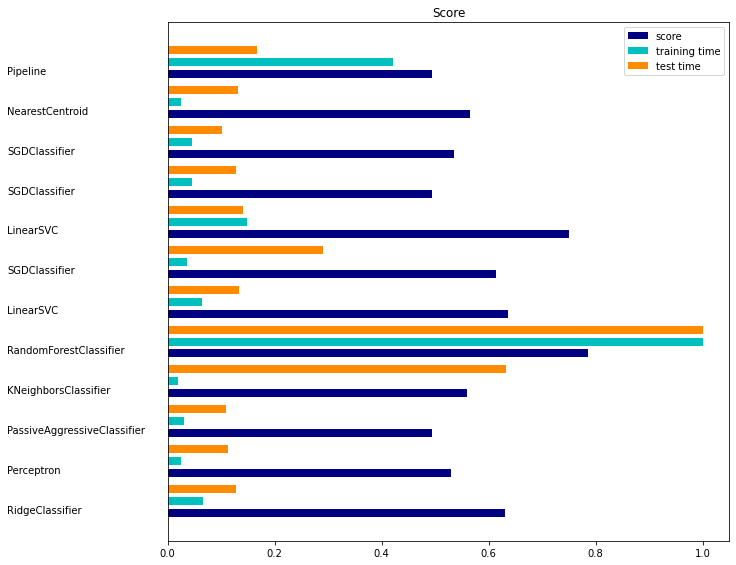

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
# clf_names, score, training_time, test_time = results
for i in range(len(score)):
  if score[i]==max(score):
    print(clf_names[i])
print(max(score))


RandomForestClassifier
0.7857142857142857


# Scaling

In [ ]:
scale_cols=['count_of_spaces',
       'count_capitals', 'count_nouns', 'count_adjectives', 'count_numbers',
       'count_NNS', 'count_NNP', 'count_NNPS', 'count_RBS', 'count_RBR',
       'count_WP', 'count_WP$', 'count_WRB', 'count_PRP', 'count_POS',
       'count_FW', 'count_VB', 'count_VBD', 'count_VBG', 'count_VBN',
       'count_CC', 'count_DT', 'count_UH', 'count_SYM', 'count_PDT',
       'count_LS', 'count_3rd person', 'count_gerund']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[scale_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
scaled_features = scaler.transform(X[scale_cols])

In [ ]:
X=X.drop(scale_cols,axis=1)

In [ ]:
df_feat = pd.DataFrame(scaled_features)
X=pd.concat([df_feat.reset_index(),X.reset_index()],axis=1)
X.drop('index',inplace=True,axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,pred))

[[71 56]
 [43 64]]


In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59       127
         1.0       0.53      0.60      0.56       107

    accuracy                           0.58       234
   macro avg       0.58      0.58      0.58       234
weighted avg       0.58      0.58      0.58       234



In [ ]:
error_rate = []
# Might take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

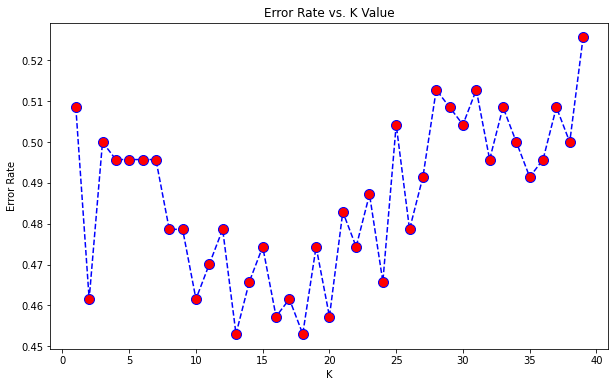

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
error_rate[15:20]

[0.45726495726495725,
 0.46153846153846156,
 0.452991452991453,
 0.47435897435897434,
 0.45726495726495725]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [ ]:
pred = knn.predict(X_test)
# ​print('WITH K=3')
# print('\n')
# print(confusion_matrix(y_test,pred))
# print('\n')
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.55      0.56      0.55       120
         1.0       0.53      0.52      0.52       114

    accuracy                           0.54       234
   macro avg       0.54      0.54      0.54       234
weighted avg       0.54      0.54      0.54       234



In [ ]:
knn.kneighbors()

(array([[33.83956622, 39.83860866, 41.00113666, ..., 56.47142549,
         56.84023436, 57.78198823],
        [33.84372311, 37.1502425 , 43.49560323, ..., 54.34843916,
         54.38486319, 56.36907793],
        [39.30335765, 39.49987724, 40.08974478, ..., 51.76446339,
         52.31431086, 53.69241587],
        ...,
        [45.80180207, 47.15859022, 47.66471127, ..., 56.80546231,
         57.06039665, 57.29016581],
        [38.77453709, 43.97389931, 49.97865027, ..., 72.28427324,
         72.5016754 , 73.69257908],
        [41.85479569, 44.35853725, 45.55683029, ..., 54.20354162,
         54.27170115, 54.35791994]]),
 array([[420, 476, 106, ..., 344, 352, 456],
        [337,   8, 419, ..., 405, 466, 484],
        [378, 134,  48, ..., 530, 102, 218],
        ...,
        [376, 271, 140, ..., 155, 384,  64],
        [504,  44, 248, ..., 101, 268, 135],
        [432, 224, 235, ..., 357, 232, 119]]))

In [ ]:
knn.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

# Lasso CV feature importance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

reg = ()
reg.fit(X_train,y_train)


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [ ]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Best alpha using built-in LassoCV: 0.038857
Best score using built-in LassoCV: 0.057427
Lasso picked 5 variables and eliminated the other 26 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

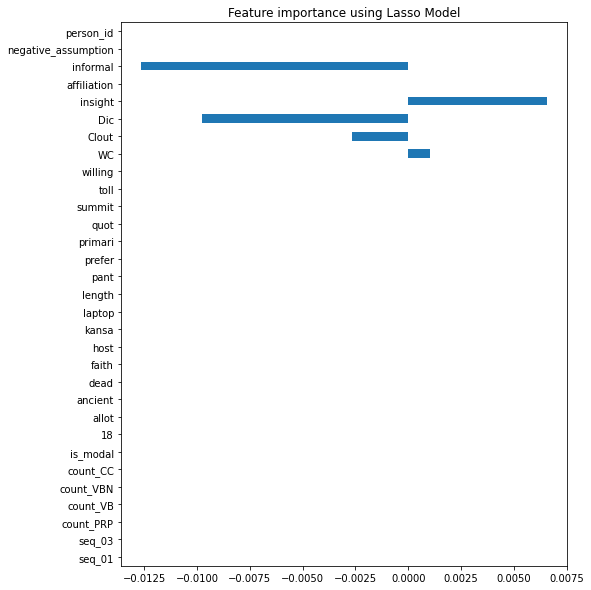

In [ ]:

imp_coef = coef[coef>0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Feature: seq_01, Score: 0.00482
Feature: seq_03, Score: 0.12913
Feature: count_PRP, Score: 0.06475
Feature: count_VB, Score: 0.17046
Feature: count_VBN, Score: 0.11972
Feature: count_CC, Score: -0.11299
Feature: is_modal, Score: -0.08309
Feature: 18, Score: -0.01268
Feature: allot, Score: 0.11807
Feature: ancient, Score: 0.31158
Feature: dead, Score: 0.07510
Feature: faith, Score: 0.02502
Feature: host, Score: -0.10825
Feature: kansa, Score: -1.60222
Feature: laptop, Score: 0.08241
Feature: length, Score: -0.71653
Feature: pant, Score: -2.45277
Feature: prefer, Score: 0.77625
Feature: primari, Score: 1.98003
Feature: quot, Score: 0.00467
Feature: summit, Score: -0.35958
Feature: toll, Score: 0.92188
Feature: willing, Score: 0.27831
Feature: WC, Score: -0.02711
Feature: Clout, Score: -0.21584
Feature: Dic, Score: -0.25761
Feature: insight, Score: 0.20453
Feature: affiliation, Score: 0.11716
Feature: informal, Score: -0.14273
Feature: negative_assumption, Score: -0.23828
Feature: person_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


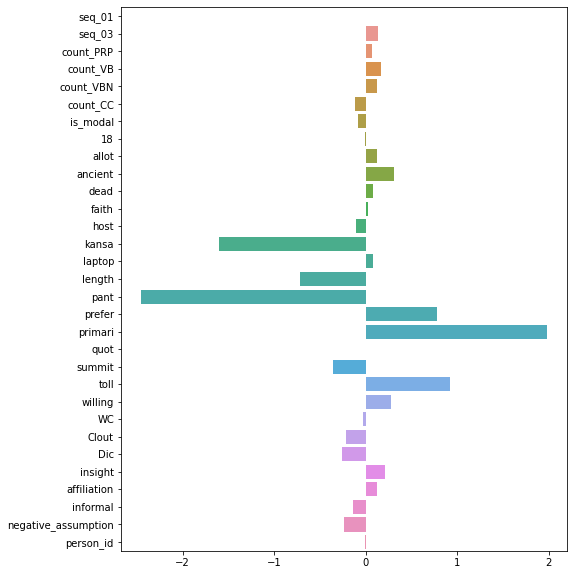

In [ ]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
scale = StandardScaler().fit(X_train)
X_train2 = scale.transform(X_train)
X_test2 = scale.transform(X_test)
model.fit(X_train2, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X_train.columns[i],v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()
# f, ax = plt.subplots(figsize=(6, 15))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


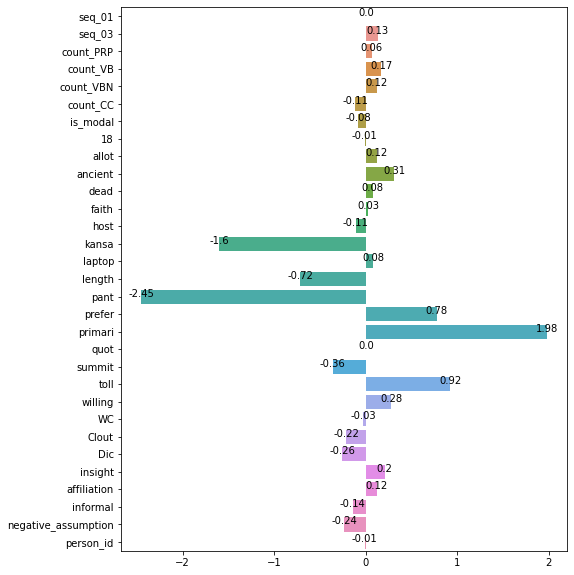

In [ ]:
b=sns.barplot(importance, X_train.columns, orient='h')

# for index, row in importance.iterrows():
#     b.text(row.name,importance[index], importance[index], color='black', ha="center")
for index, row in enumerate(importance):
    b.text( importance[index],index, round(importance[index],2),color='black', ha="center")

# Random Forest hyperparameter tuning

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.737 (0.060)


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=27,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier()
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
y_pred=clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80        80
         1.0       0.81      0.79      0.80        84

    accuracy                           0.80       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.80      0.80      0.80       164



In [ ]:
X.shape, X_test

((863, 1184),
      seq_01  seq_03  count_PRP  ...  informal  negative_assumption  person_id
 8      True    True         20  ...      0.60                    0          9
 39     True    True          3  ...      0.00                    0          9
 70     True   False          5  ...      4.35                    0          9
 101    True    True         24  ...      1.82                    0          9
 132    True    True          8  ...      4.55                    0          9
 ..      ...     ...        ...  ...       ...                  ...        ...
 771    True    True          8  ...      8.20                    0         28
 802    True    True         11  ...      2.96                    1         28
 833    True    True          7  ...      0.00                    0         28
 863    True    True          6  ...      0.00                    0         28
 893   False   False          2  ...      0.00                    0         28
 
 [164 rows x 31 columns])

In [ ]:
X_train.shape

(693, 1184)

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns ).sort_values(ascending=False)
feature_imp

prefer                 0.109589
pant                   0.105027
kansa                  0.090176
primari                0.077658
ancient                0.067962
toll                   0.064609
willing                0.059755
faith                  0.059480
allot                  0.056054
quot                   0.053600
dead                   0.050041
WC                     0.026034
count_PRP              0.024669
insight                0.020455
laptop                 0.020029
Dic                    0.017899
Clout                  0.016063
length                 0.014342
count_VB               0.014322
informal               0.012022
affiliation            0.008326
person_id              0.007176
18                     0.006479
count_VBN              0.004592
count_CC               0.004207
seq_03                 0.003976
is_modal               0.002179
negative_assumption    0.002022
seq_01                 0.001088
summit                 0.000171
host                   0.000000
dtype: f

2021-06-15 14:46:45,564 WARNING No handles with labels found to put in legend.


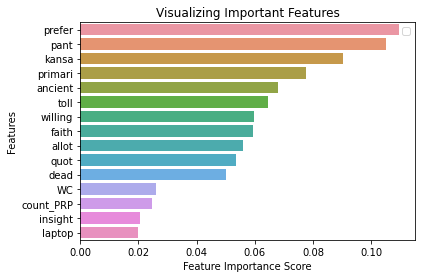

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:15], y=feature_imp.index[:15])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

2021-06-15 14:46:59,744 WARNING No handles with labels found to put in legend.


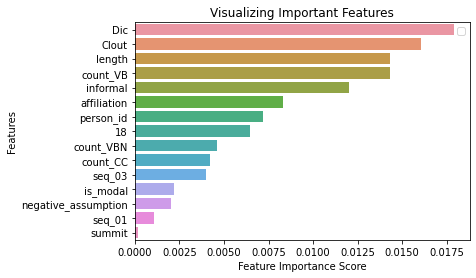

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[15:30], y=feature_imp.index[15:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

>1 0.733 (0.050)
>2 0.735 (0.046)
>3 0.741 (0.054)
>4 0.728 (0.051)
>5 0.735 (0.045)
>6 0.734 (0.040)
>7 0.734 (0.038)
>8 0.735 (0.050)
>9 0.736 (0.061)
>10 0.735 (0.048)
>11 0.731 (0.053)
>12 0.731 (0.045)
>13 0.728 (0.059)
>14 0.725 (0.048)
>15 0.732 (0.047)
>16 0.719 (0.047)
>17 0.725 (0.056)
>18 0.725 (0.054)
>19 0.719 (0.051)


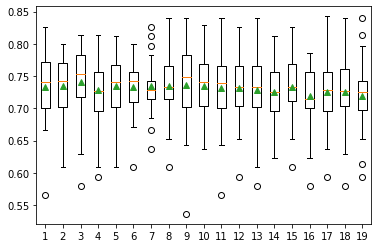

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 
# # get the dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# 	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,20):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>20 0.730 (0.047)
>21 0.730 (0.049)
>22 0.732 (0.053)
>23 0.723 (0.055)
>24 0.724 (0.049)
>25 0.726 (0.047)
>26 0.731 (0.047)
>27 0.724 (0.055)
>28 0.722 (0.050)
>29 0.719 (0.052)


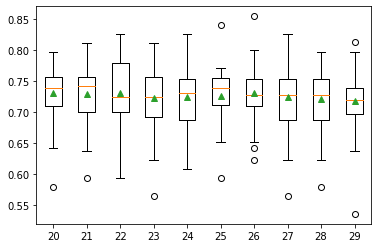

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 
# # get the dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# 	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 20 t0 30
	for i in range(20,30):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model,X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.680 (0.052)
>2 0.702 (0.053)
>3 0.709 (0.050)
>4 0.733 (0.042)
>5 0.737 (0.043)
>6 0.751 (0.044)
>7 0.747 (0.048)
>None 0.732 (0.055)


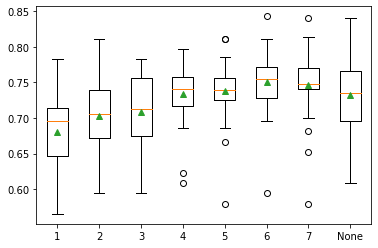

In [ ]:
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [i for i in range(1,8)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>8 0.735 (0.046)
>9 0.749 (0.047)
>10 0.739 (0.050)
>11 0.739 (0.052)
>12 0.731 (0.049)
>13 0.740 (0.049)
>14 0.737 (0.050)
>None 0.735 (0.047)


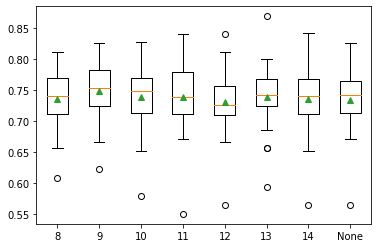

In [ ]:
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [i for i in range(8,15)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model,X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>15 0.734 (0.053)
>16 0.735 (0.047)
>17 0.732 (0.055)
>18 0.737 (0.049)
>19 0.738 (0.055)


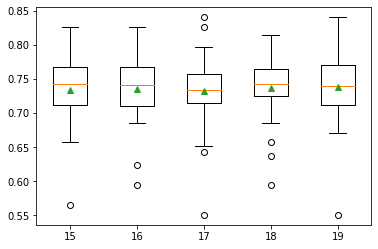

In [ ]:
 # get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [i for i in range(15, 20)] 
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.706 (0.054)
>50 0.732 (0.049)
>100 0.736 (0.052)
>500 0.736 (0.048)
>1000 0.737 (0.049)


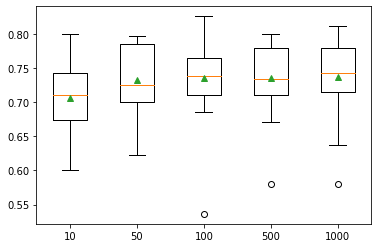

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
# X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train,y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
#Create a Gaussian Classifier for merge data
clf=RandomForestClassifier(n_estimators=1000
                           ,max_depth=6
                          #  ,max_features=28
                           )
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79        83
         1.0       0.83      0.69      0.76        85

    accuracy                           0.77       168
   macro avg       0.78      0.77      0.77       168
weighted avg       0.78      0.77      0.77       168



#PCA

In [ ]:
import numpy as np
import struct
from sklearn.decomposition import PCA
from keras.datasets import mnist

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y , test_size=0.33, random_state=42)

In [ ]:
pca = PCA(n_components = 100)
pca.fit(X_train) #fit PCA with training data instead of the whole dataset
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print("PCA completed with 100 components")
# print ("training data shape after PCA:",train_data_pca.shape)
# print ("testing data shape after PCA:",test_data_pca.shape)


PCA completed with 100 components


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 20

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

y_predict = knn_model.predict(X_test)
print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         0.0       0.57      0.56      0.57       144
         1.0       0.49      0.50      0.50       122

    accuracy                           0.53       266
   macro avg       0.53      0.53      0.53       266
weighted avg       0.53      0.53      0.53       266



Text(0, 0.5, 'Error Rate')

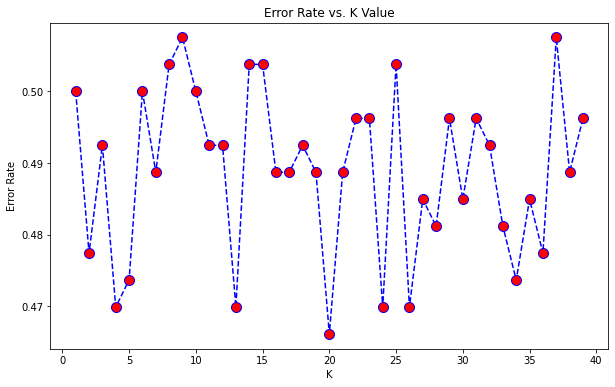

In [ ]:
error_rate = []
# Might take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
error_rate[0]

0.5

In [ ]:
import numpy as np
import pandas as pd

# For chapter 4
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For chapter 5
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import time

# For chapter 6
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
trainX = scaler.transform(X_train)
testX = scaler.transform(X_test)
clf = SGDClassifier(loss="log", penalty="l2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.48


In [ ]:
pca = PCA(n_components=100)
train_features = pca.fit_transform(X_train)

rfr = RandomForestClassifier(n_estimators = 100, n_jobs = 10, 
                                         random_state = 2016, verbose = 1,
                                         class_weight='balanced',oob_score=True)

rfr.fit(train_features,y_train)

test_features = pca.transform(X_test)
y_pred=rfr.predict(test_features)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.42      0.47       142
         1.0       0.45      0.55      0.50       124

    accuracy                           0.48       266
   macro avg       0.49      0.49      0.48       266
weighted avg       0.49      0.48      0.48       266



# glove embedding

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/
import pandas as pd
liwc_features  = pd.read_csv('result_files/liwc_final.csv')

Mounted at /gdrive
/gdrive
/gdrive/MyDrive


In [ ]:
embeddings_index = dict()
f = open('../input/glove6b/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# word cloud

In [ ]:
df.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8', 'Feature9', 'Feature10',
       ...
       'I (The respondent) [Am exacting in my work.]_Neutral',
       'I (The respondent) [Am exacting in my work.]_Slightly agree',
       'I (The respondent) [Am exacting in my work.]_Slightly disagree',
       'I (The respondent) [Often feel blue.]_Disagree',
       'I (The respondent) [Often feel blue.]_Neutral',
       'I (The respondent) [Often feel blue.]_Slightly agree',
       'I (The respondent) [Often feel blue.]_Slightly disagree',
       'I (The respondent) [Am full of ideas.]_Neutral',
       'I (The respondent) [Am full of ideas.]_Slightly agree',
       'I (The respondent) [Am full of ideas.]_Slightly disagree'],
      dtype='object', length=1211)

In [ ]:
df.rename({'Source (D)': 'transcript'},axis = 1, inplace=True

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df[df.y==1].transcript

0      So the rule is about software development, and...
1      I believe that this role is going to expose me...
2      OK, yeah, so the fact that I'll be able I'll b...
3      All. I just talked about the. So the profile t...
4      Well it was something I was born to do. I've b...
                             ...                        
860    Yeah, so I when I was in class seven I. Watch ...
861                  Have actually I went to. I'm sorry.
862    I was 18 years old when I decided to pursue my...
865    I think I was about 2322 when I first realized...
866    I was around 14 years after graduating from te...
Name: transcript, Length: 441, dtype: object